In [1]:
# Import packages
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import warnings
import errno
import numpy as np
import datetime
import tensorflow as tf
import argparse
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from skimage.filters import sobel_h
from skimage.filters import sobel_v
from skimage.measure import label
from skimage.measure import regionprops
from skimage.transform import resize
from skimage.external import tifffile as tiff
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import random_channel_shift
from tensorflow.python.keras.preprocessing.image import apply_transform
from tensorflow.python.keras.preprocessing.image import flip_axis
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import to_categorical as keras_to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.python.keras.optimizers import SGD,Adam

from deepcell import get_image_sizes
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell import bn_multires_feature_net
from deepcell import disc_net
from deepcell import discriminative_instance_loss
from deepcell import DiscDataGenerator
from deepcell import train_model_fgbg, train_model_disc
from deepcell.utils.transform_utils import transform_matrix_offset_center
from deepcell.utils.transform_utils import distance_transform_2d
from deepcell.image_generators import ImageFullyConvDataGenerator
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.utils.io_utils import get_images_from_directory
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.transform_utils import to_categorical
from deepcell.settings import CHANNELS_FIRST

In [2]:
# data options
DATA_OUTPUT_MODE = 'conv'
BORDER_MODE = 'valid' if DATA_OUTPUT_MODE == 'sample' else 'same'
RESIZE = True
RESHAPE_SIZE = 256

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/unspecified_nuclear_data/nuclei/'
DATA_FILE = 'disc_{}_{}'.format(K.image_data_format(), DATA_OUTPUT_MODE)

for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
    except OSError as exc: # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise
            

In [ ]:
# Generate training data
file_name_save = os.path.join(NPZ_DIR, PREFIX, DATA_FILE)
num_of_features = 2 # Specify the number of feature masks that are present
window_size = (30, 30) # Size of window around pixel
training_direcs = ['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8', 'set9']
channel_names = ['nuclear']
raw_image_direc = ''
annotation_direc = ''

# Create the training data
make_training_data(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    dimensionality=2,
    max_training_examples=1e6, # Define maximum number of training examples
    window_size_x=window_size[0],
    window_size_y=window_size[1],
    border_mode=BORDER_MODE,
    file_name_save=file_name_save,
    training_direcs=training_direcs,
    channel_names=channel_names,
    num_of_features=num_of_features,
    raw_image_direc=raw_image_direc,
    annotation_direc=annotation_direc,
    reshape_size=RESHAPE_SIZE if RESIZE else None,
    edge_feature=[1, 0, 0], # Specify which feature is the edge feature,
    dilation_radius=1,
    output_mode=DATA_OUTPUT_MODE,
    display=False,
    verbose=True)


In [3]:
# Foreground/background model
direc_save = os.path.join(MODEL_DIR, PREFIX)
direc_data = os.path.join(NPZ_DIR, PREFIX)
training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

class_weights = training_data['class_weights']
X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

n_epoch = 10
batch_size = 32 if DATA_OUTPUT_MODE == 'sample' else 1
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

model_args = {
}

data_format = K.image_data_format()
row_axis = 2 if data_format == 'channels_first' else 1
col_axis = 3 if data_format == 'channels_first' else 2
channel_axis = 1 if data_format == 'channels_first' else 3

the_model = bn_multires_feature_net

size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
if data_format == 'channels_first':
    model_args['input_shape'] = (X.shape[channel_axis], size[0], size[1])
else:
    model_args['input_shape'] = (size[0], size[1], X.shape[channel_axis])
model_args['n_features'] = 3
model_args['location'] = False

fgbg_model = the_model(**model_args)

train_model_fgbg(
    model=fgbg_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=direc_save,
    direc_data=direc_data,
    lr_sched=lr_sched,
    class_weight=class_weights,
    rotation_range=180,
    flip=True,
    shear=True)

X.shape: (225, 256, 256, 1)
y.shape: (225, 256, 256, 3)
X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Epoch 1/10
201/202 [============================>.] - ETA: 0s - loss: 0.3595 - acc: 0.7965
Epoch 00001: val_loss improved from inf to 1.13193, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-11_fgbg__0.h5
202/202 [==============================] - 27s 132ms/step - loss: 0.3590 - acc: 0.7964 - val_loss: 1.1319 - val_acc: 0.4821
Epoch 2/10
201/202 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.8217
Epoch 00002: val_loss did not improve
202/202 [==============================] - 18s 89ms/step - loss: 0.3011 - acc: 0.8215 - val_loss: 1.7480 - val_acc: 0.4091
Epoch 3/10
201/202 [============================>.] - ETA: 0s - loss: 0.2914 - acc: 0.8365
Epoch 00003: val_loss improved from 1.13193 to 0.57389, sa

In [4]:
# Disc model
direc_save = os.path.join(MODEL_DIR, PREFIX)
direc_data = os.path.join(NPZ_DIR, PREFIX)
training_data = np.load(os.path.join(direc_data, DATA_FILE + '.npz'))

class_weights = training_data['class_weights']
X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

n_epoch = 10
batch_size = 32 if DATA_OUTPUT_MODE == 'sample' else 1
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

data_format = K.image_data_format()
row_axis = 2 if data_format == 'channels_first' else 1
col_axis = 3 if data_format == 'channels_first' else 2
channel_axis = 1 if data_format == 'channels_first' else 3

model_args_disc_net = {}
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[row_axis:col_axis + 1]
if data_format == 'channels_first':
    model_args_disc_net['input_shape'] = (X.shape[channel_axis], size[0], size[1])
else:
    model_args_disc_net['input_shape'] = (size[0], size[1], X.shape[channel_axis])
model_args_disc_net['norm_method'] = 'std'
model_args_disc_net['n_features'] = 2
model_args_disc_net['seg_model'] = fgbg_model
model_args_disc_net['softmax'] = False

disc_model = disc_net(**model_args_disc_net)

train_model_disc(
    model=disc_model,
    dataset=DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    direc_save=direc_save,
    direc_data=direc_data,
    lr_sched=lr_sched,
    class_weight=class_weights,
    rotation_range=180,
    flip=True,
    shear=True)

X.shape: (225, 256, 256, 1)
y.shape: (225, 256, 256, 3)
X_train shape: (202, 256, 256, 1)
y_train shape: (202, 256, 256, 3)
X_test shape: (23, 256, 256, 1)
y_test shape: (23, 256, 256, 3)
Output Shape: (None, 256, 256, 2)
Number of Classes: 2
Epoch 1/10
201/202 [============================>.] - ETA: 0s - loss: 5.6212
Epoch 00001: val_loss improved from inf to 5.95922, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-11_disc_channels_last_conv__0.h5
202/202 [==============================] - 45s 221ms/step - loss: 5.6293 - val_loss: 5.9592
Epoch 2/10
201/202 [============================>.] - ETA: 0s - loss: 5.5872
Epoch 00002: val_loss improved from 5.95922 to 4.59133, saving model to /data/models/cells/unspecified_nuclear_data/nuclei/2018-07-11_disc_channels_last_conv__0.h5
202/202 [==============================] - 36s 177ms/step - loss: 5.5806 - val_loss: 4.5913
Epoch 3/10
201/202 [============================>.] - ETA: 0s - loss: 5.5772
Epoch 00003: val_l

In [7]:
training_data_file_name = os.path.join(direc_data, DATA_FILE + '.npz')
train_dict, (X_test, y_test) = get_data(training_data_file_name, mode='conv')

test_images = disc_model.predict(X_test)
test_images_fgbg = fgbg_model.predict(X_test)
test_images.shape

(23, 256, 256, 2)

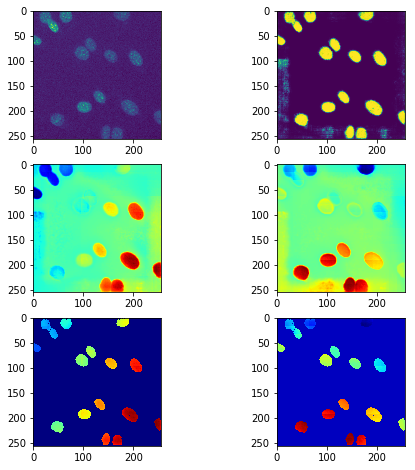

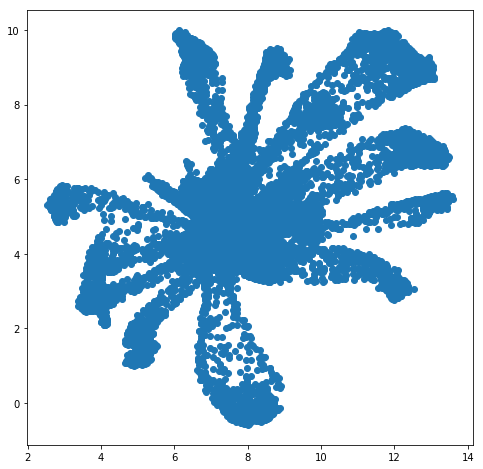

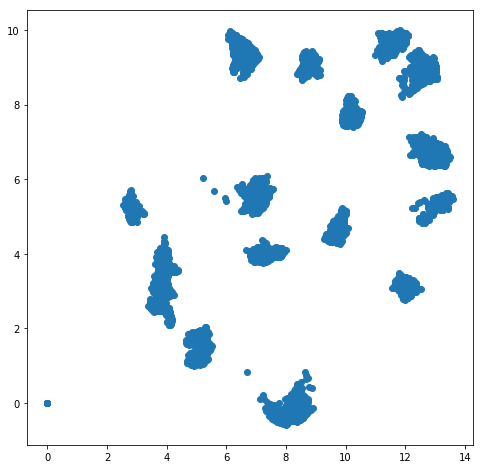

In [9]:
import matplotlib.pyplot as plt
fig_size = [None,None]
fig_size[0] = 8
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
test_images_post_fgbg=test_images[:,:,:,:]*np.expand_dims(test_images_fgbg[:,:,:,1]>0.8,axis=-1)

index=0

plt.subplot(3,2,1)
plt.imshow(X_test[index,:,:,0])
plt.subplot(3,2,2)
plt.imshow(test_images_fgbg[index,:,:,1])
plt.subplot(3,2,3)
plt.imshow(test_images[index,:,:,0], cmap='jet')
plt.subplot(3,2,4)
plt.imshow(test_images[index,:,:,1], cmap='jet')
plt.subplot(3,2,5)
plt.imshow(test_images_post_fgbg[index,:,:,0], cmap='jet')
plt.subplot(3,2,6)
plt.imshow(test_images_post_fgbg[index,:,:,1], cmap='jet')

plt.figure()
test_plot = test_images[index,:,:,:].reshape(-1,2)
plt.scatter(x=test_plot[:,0], y=test_plot[:,1])

plt.figure()
test_plot = test_images_post_fgbg[index,:,:,:].reshape(-1,2)
plt.scatter(x=test_plot[:,0], y=test_plot[:,1])

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_images= pca.fit(test_images_post_fgbg.reshape(-1,16))

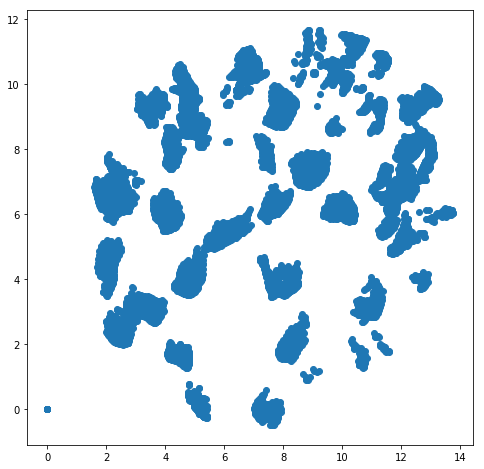

In [11]:
index = 4
test_plot = test_images_post_fgbg[index,:,:,:].reshape(-1,2)
plt.scatter(x=test_plot[:,0], y=test_plot[:,1])

# pca_test = pca_images.transform(test_images_post_fgbg[1,:,:,:].reshape(-1,16))
# plt.scatter(x = test_images[[:,0], y= pca_test[:,1])